# Introduction
Identifying individuals in a group of animals is an active research topic as it paves the way to behavioural studies, including lameness and illness detection. In this notebook, we replicated an identification technique that proposes metric learning for open-set identification of Holstein-Friesian cattle (i.e. identifying unknown cattle, not trained against, not requiring any training) [<sup>[1]</sup>](#fn1). To train a convolutional neural network, we used a opensource dataset called [OpenCows2020](https://data.bris.ac.uk/data/dataset/10m32xl88x2b61zlkkgz3fml17) [<sup>[2]</sup>](#fn2) released under [Non-Commercial Government Licence for public sector information](http://www.nationalarchives.gov.uk/doc/non-commercial-government-licence/non-commercial-government-licence.htm).

We then test the trained model's embedding to evaluate if they are quantifiably unique using K-nearest neighbours, and each value in the embedding is an independent variable (no correlation). Finally, using TSNE dimensionality reduction, we visualize the embeddings for individuals.

> 📓 **This is a faithful (from scratch) re-implementation of the orignal paper with the focus on using the PyTorch builtin functions. The orignal repository associated with the Andrew et al. paper[<sup>[1]</sup>](#fn1) uses a custom resnet `nn.module`, whereas here, we directly rely on what pytorch can offer. It is worth noting that, the results presented here, challenge the results from the Andrew et al. paper[<sup>[1]</sup>](#fn1) (we achieve a higher accuracy), the cause of which might be atribited to minor oversights to the pytorch documentation by the orignal authors and the different model training routine used here.**

In [2]:
# Uncomment to following to install the depedencies
!pip install hiddenlayer
!pip3 install graphviz
!pip3 install tqdm

import os # For directory listing

# Maing dependency is pytorch
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
from torchvision import transforms

# For visualization
import matplotlib.pyplot as plt
import hiddenlayer as hl
import numpy

# Progress
from tqdm import tqdm

# Model evaluation
from sklearn.neighbors import KNeighborsClassifier

# Methods

## Opencows dataset exploration
### Configuring the dataset
* **Clone the [OpenCows2020Dataset](https://github.com/Asheeshkrsharma/OpenCows2020Dataset.git) repository by [Asheeshkrsharma](https://github.com/Asheeshkrsharma)(me)**

    The `OpenSetCows2020` pytorch class was modified because the orignal repository that comes with the paper[<sup>[1]</sup>](#fn1) *does not* normalize images around the mean as required by the pytorch model zoo weights (see [line 183](https://github.com/CWOA/MetricLearningIdentification/blob/1ae50c819da735901fd21a7f19293092bb0b2422/datasets/OpenSetCows2020/OpenSetCows2020.py#L183) in `OpenCows2020.py`). The following is quoted directly from the pytorch [documentation](https://pytorch.org/vision/stable/models.html):

    > All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. You can use the following transform to normalize:
    ```python
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    ```
* Instead of downloading the entire dataset (~2 GB), download just the identification part using `xargs` and `wget`. The [data.bris.ac.uk](https://data.bris.ac.uk/data/dataset/10m32xl88x2b61zlkkgz3fml17) `CKAN` server is relatively slow; it takes more than 2 hours to download the entire dataset. Just downloading the identification part reduces the download time to about three minutes.

The following wraps all the command-lines inside the notebook

> ⚠️ **wget is required to download the dataset (on mac run `brew install wget`). Alternatively, please download the entire dataset and places the contents of the identification folder (`images` & `splits`) into the datasets/OpenSetCows2020 directory.**

In [3]:
url = "https://data.bris.ac.uk/"
with tqdm(range(2), desc="Preparing dataset") as pbar:
  tqdmDescribe = lambda message, pbar: pbar.set_description(message); pbar.refresh()
  files = list(open("./utils/datasetLinks.txt", "r").readlines())
  tqdmDescribe(f"Downloading OpenSetCows2020 ({len(files)} files from {url})", pbar)
  # This downloads a 500 files concurrently using wget. (takes roughly 2 minutes)
  !rm -rf datasets && cat ./utils/datasetLinks.txt | xargs -n 500 -P 8 wget -x -nH -q
  pbar.update()
  tqdmDescribe(f"Organizing dataset", pbar)
  !mkdir -p datasets/OpenSetCows2020
  !mv -f ./datasets/*/identification/* ./datasets/OpenSetCows2020/ 2>/dev/null
  !rm -rf ./datasets/10m32xl88x2b61zlkkgz3fml17
  pbar.update()

Organizing dataset: 100%|██████████| 2/2 [01:05<00:00, 32.53s/it]                                                    


### Reading the dataset
The `OpenSetCows2020` PyTorch dataset class implementation was modified to normalize the image to `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]` as recommended by the PyTorch documentation. As a result, the image data is transformed to contain negative values, which causes clipping when calling the `plt.imshow` function. To remidiate this issue, the images are temprorily "untransformed" for viewing purposes. Following custom transform from [this](https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3) pytorch discussion forum was used to revert mean normalization (See [this](https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3) comment by [Joel Simon](https://discuss.pytorch.org/u/joels/summary)):
```python
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
```

This dataset (train split, 1 fold) has 35 known and 11 unknown categories, with combinations turned on.
It has 4240 images in the train set and 496 in the test set.
You can try to plot the triplet samples by `dataset.plotSamples(<number of samples>)`, and see the distribution by `dataset.distribution()`


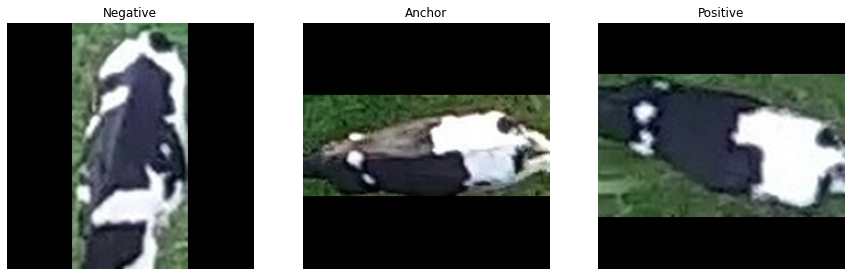

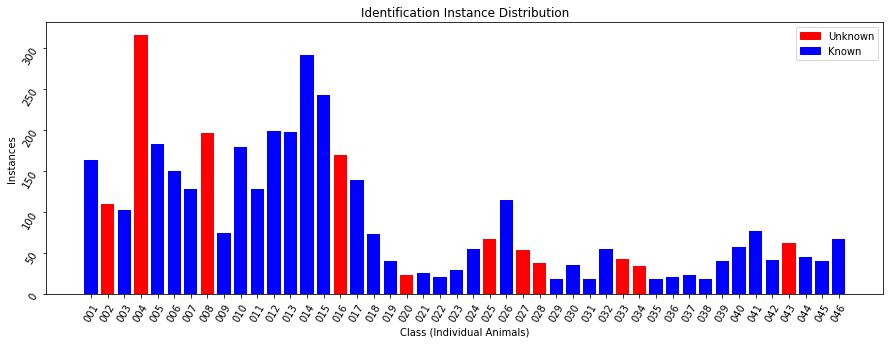

In [3]:
# I have modified the underlying nn.dataset class to make the figures.
from utils.OpenSetCows2020 import OpenSetCows2020

foldsFile = "datasets/OpenSetCows2020/splits/75-25.json"

trainDataset = OpenSetCows2020(
    0,  # Fold 0
    foldsFile,
    split="train",
    transform=True,  # --------⎤
    combine=True,  # -----------> Arguments taken as specified in the Paper.
    suppress_info=False,  # ---⎦
)

plt.rcParams["figure.figsize"] = (15, 5)
trainDataset.plotSamples(1)
trainDataset.distribution()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

## ResNet based model for deep metric learning
### Construction
Andrew Et al. [<sup>[1]</sup>](#fn1) proposed a ResNet model as a backbone for features which can then be reduced to a one-dimensional embedding. The idea is to represent individual cows using the embedding in a latent space that can be classified with algorithms such as K-nearest neighbours. In theory, unknown individual embeddings (ones not seen during the training) should be significantly distant if the model had learnt discriminative features, eliminating the need for re-training to account for new individuals.

The study used the Resnet50 [<sup>[3]</sup>](#fn3) model with pre-trained weight from Imagenet, which can be found [here](https://pytorch.org/vision/stable/models.html). We used `resnet50-19c8e357.pth `

In [4]:
class ResNetMod(nn.Module):
    def __init__(self, numClasses, embeddingSize=128):
        """Initialize the model

        Parameters
        ----------
        numClasses : Int
            Number of classes (or individuals in a dataset)
        embeddingSize : Int, optional
            Size of the final embedding used differentiate individuals

        Returns
        -------
        A ResNetMod class instance
        """
        super(ResNetMod, self).__init__()

        # We create a resnet50 block and load imagenet weight into it
        self.backbone = models.resnet50(pretrained=True)
        imagenetWeights = model_zoo.load_url(
            "https://download.pytorch.org/models/resnet50-19c8e357.pth"
        )
        self.backbone.load_state_dict(imagenetWeights)

        # This layers is trained again, bias is set to true.
        self.backbone.fc = nn.Linear(2048, 1000)
        self.relu = nn.ReLU(inplace=True)
        self.embedding = nn.Linear(1000, embeddingSize)
        self.softmax = nn.Linear(1000, numClasses)

    def forwardOnce(self, x):
        """Forward through the network once

        Parameters
        ----------
        x : Input image to embed
            [Batch Size, Channel, Width, Height]

        Returns
        -------
        Embedding
            [Batch Size, 128]
        Softmax
            [Batch Size, Num Classes]
        """

        # Conv1 -> Relu(bn1) -> maxpool
        x = self.backbone.maxpool(
            self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        )
        # avgpool(Layer 1 -> Layer 2 -> Layer 3 -> Layer 4)
        x = self.backbone.avgpool(
            self.backbone.layer4(
                self.backbone.layer3(self.backbone.layer2(self.backbone.layer1(x)))
            )
        )
        # Relu(FC)
        x = self.relu(self.backbone.fc(x.view(x.size(0), -1)))
        return self.embedding(x), self.softmax(x)

    def forward(self, anchor, negative=None, positive=None):
        """Forward the network

        Parameters
        ----------
        anchor : Input image to embed
            [Batch Size, Channel, Width, Height]
        negative : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss
        positive : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss

        Returns
        -------
        list
            Embeddings and softmax ouputs for negative, anchor,
            and postive triplets in case nagative and postive
            image inputs are provided. Otherwise, returns a
            single embedding and softmax output.
        """
        if (negative != None) & (positive != None):
            negativeEMBD, negativeSMax = self.forwardOnce(negative)
            anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            positiveEMBD, positiveSMax = self.forwardOnce(positive)
            return (
                negativeEMBD, anchorEMBD, positiveEMBD,
                torch.cat((negativeSMax, anchorSMax, positiveSMax), 0),
            )
        else:
            anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            return anchorEMBD, anchorSMax

    def __repr__(self):
        summary = f"{self.backbone.conv1.__repr__()} \n{self.backbone.bn1.__repr__()}"
        summary += "\nResnet Backbone: \n"
        layers = [
            self.backbone.layer1, self.backbone.layer2,
            self.backbone.layer3, self.backbone.layer4,
        ]
        for layer in layers:
            parameters = list(layer.named_parameters())
            summary += (
                f"\t ⎣ Input: {list(parameters[0][1].size())}"
                + f" -> Output: {list(parameters[-1][1].size())} ↩\n"
            )
        summary += self.backbone.fc.__repr__()
        summary += "\nOutput 1: " + self.embedding.__repr__()
        summary += "\nOutput 2: " + self.softmax.__repr__()
        return summary


### Model summary and Visualization

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Resnet Backbone: 
	 ⎣ Input: [64, 64, 1, 1] -> Output: [256] ↩
	 ⎣ Input: [128, 256, 1, 1] -> Output: [512] ↩
	 ⎣ Input: [256, 512, 1, 1] -> Output: [1024] ↩
	 ⎣ Input: [512, 1024, 1, 1] -> Output: [2048] ↩
Linear(in_features=2048, out_features=1000, bias=True)
Output 1: Linear(in_features=1000, out_features=128, bias=True)
Output 2: Linear(in_features=1000, out_features=46, bias=True)


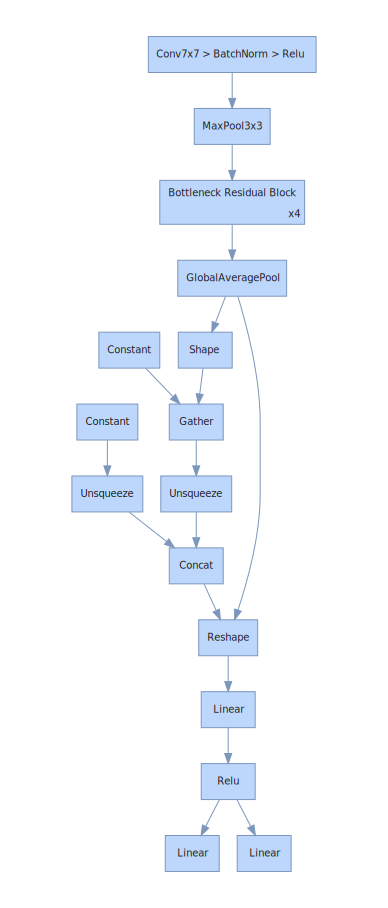

In [5]:
# Create the model and load weights (imagenet)
model = ResNetMod(trainDataset.getNumClasses())
print(model)

# Use tranforms from hidden layer library, to hide some block
# otherwise the graph will be too long.
transforms = [
    # Fold Conv, BN, RELU layers into one
    hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"),
    # Fold Conv, BN layers together
    hl.transforms.Fold("Conv > BatchNorm", "ConvBn"),
    # Fold bottleneck blocks
    hl.transforms.Fold(
        "((ConvBnRelu > ConvBnRelu > ConvBn) | ConvBn) > Add > Relu",
        "BottleneckBlock",
        "Bottleneck Block",
    ),
    # Fold residual blocks
    hl.transforms.Fold(
        "ConvBnRelu > ConvBnRelu > ConvBn > Add > Relu", "ResBlock", "Residual Block"
    ),
    hl.transforms.Fold("Flatten > Linear > Relu > Linear", "Embded", "Embedding layer"),
    # Fold repeated blocks
    hl.transforms.FoldDuplicates(),
    hl.transforms.Fold(
        "BottleneckBlock > ResBlock", "BRes", "Bottleneck Residual Block"
    ),
    hl.transforms.FoldDuplicates(),
]
# Visualize
graph = hl.build_graph(model, torch.zeros((1, 3, 244, 244)), transforms=transforms)
graph.theme = hl.graph.THEMES["blue"].copy()
dot = graph.build_dot()
dot.attr("graph", rankdir="TD")
dot


# Loss function and the triplet mining strategy
## Loss function
Discussion on loss function quoted from the Andrew Et al. [<sup>[1]</sup>](#fn1) metric learning paper.

> $\cdots$ The problem with this [contrastive loss] formulation is that it cannot simultaneously encourage learning of visual similarities and dissimilarities, both of which are critical for obtaining clean, well-separated clusters on our coat pattern differentiation task. This shortcoming can be overcome by a triplet loss formulation; utilising the embeddings $x_a$, $x_p$, $x_n$ of a triplet containing three image inputs ($X_a$,$X_p$,$X_n$) denoting an anchor, a positive example from the same class, and a negative example from a different class, respectively. The idea being to encourage minimal distance between the anchor $x_a$ and the positive $x_p$, and maximal distance between the anchor $x_a$ and the negative sample $x_n$ in the embedded space. The loss function is given by:
> $$ \mathbb{L}_{TL} = max(0, d(x_a, x_p) - d(x_a, x_n) + \alpha)$$
> where $\alpha$ denotes a constant margin hyperparameter. The inclusion of the constant $\alpha$ often turns out to cause training issues since the margin can be satisfied at any distance from the anchor $\cdots$ a recent formulation named reciprocal triplet loss alleviates this limitation, which removes the margin hyperparameter altogether:
> $$ \mathbb{L}_{RTL} = d(x_a, x_p) + \frac{1}{d(x_a, x_n)} $$
> Recent work has demonstrated improvements in open-set recognition on various datasets via the inclusion of a SoftMax term in the triplet loss formulation during training given by:
> $$ \mathbb{L}_{SoftMax + TL} =  \mathbb{L}_{SoftMax} + \lambda \cdot \mathbb{L}_{TL} $$
> where
> $$ \mathbb{L}_{SoftMax} =  - log(\frac{e^{x_{class}}}{\sum_{i}e^{xi}}) $$
> and where $\lambda$ is a constant weighting hyperparameter and $\mathbb{L}_{TL}$ is standard triplet loss. For our experiments, we select $\lambda=0.01$ as suggested in the original paper as the result of a parameter grid search.
>
> --**Andrew Et al. [<sup>[1]</sup>](#fn1)**

Based on the discussion found above, we implemented $\mathbb{L}_{RTL}$ and $\mathbb{L}_{SoftMax + TL}$. 

> 📓 **It is worth noting that the paper mentions an example mining strategy to find non-trivial triplets, which reportedly improves model performance and requires a lower number of training iterations.**

In [7]:
# Reciprocal Triplet loss
class RTL(nn.Module):
    def __init__(self):
        super(RTL, self).__init__()

    def d(self, anchor, instance):
        return (anchor - instance).pow(2).sum(1)

    def forward(self, anchor, positive, negative):
        return self.d(anchor, positive) + 1 / self.d(anchor, negative)


# Triplet loss and softmax loss combined
class TLSL(nn.Module):
    def __init__(self, TLmargin, _lambda):
        super(TLSL, self).__init__()
        self._lambda = _lambda
        self.TL = nn.TripletMarginLoss(margin=TLmargin)
        self.CE = nn.CrossEntropyLoss()

    def forward(self, negative, anchor, positive, prediction, target):
        return (self._lambda * self.TL(anchor, positive, negative).sum()) + self.CE(
            input=prediction, target=target - 1
        )


# Model training
Contrary to the orignal approach:
* For finetuning, the `resenet50` was frozen (i.e. the weights are not update during training). Only the final softmax and embedding linear layers were trained.
* 

The `compose` lambda function can be used to composite the triplet image batch in a grid. The parameter horizontal takes a value of 0 or 1 and controls how the images are arranged. The function can be used as follows:

```python
# Load a batch from the data loader.
anchors, positives, negatives, anchorLabel, negativeLabel = next(
    iter(dataLoader)
)
# Arranged vectically first as negative, anchor, and positive, then horizoontally as a batch.
composite = compose(
    [compose(negatives, 1), compose(anchors, 1), compose(positives, 1)], 0
)
plt.imshow(composite)
```

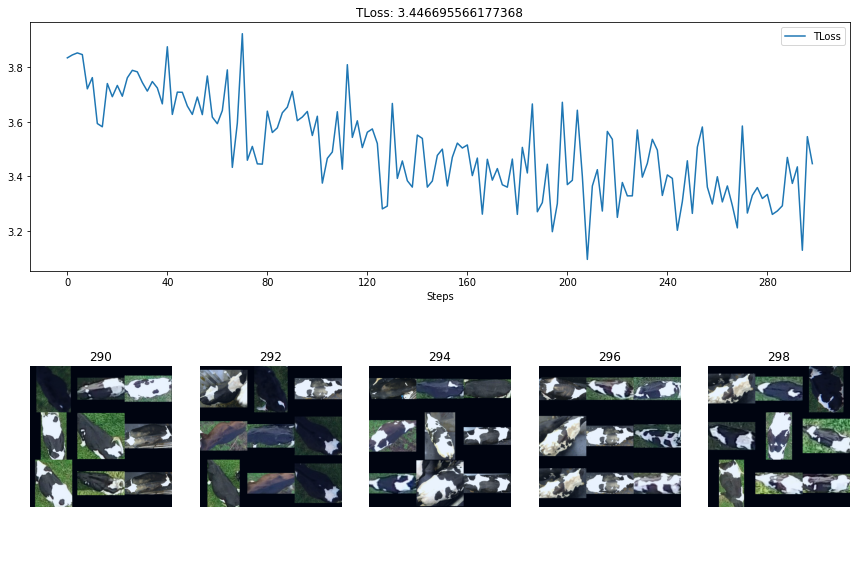

Training epochs: 100%|██████████| 300/300 [14:17<00:00,  2.86s/it]


In [44]:
def evaluate(model, dataLoader, device, lossFn):
    model.eval()
    losses = []
    for anchors, positives, negatives, anchorLabel, negativeLabel in tqdm(dataLoader):
        anchors, positives, negatives, anchorLabel, negativeLabel = (
            anchors.to(device), positives.to(device), negatives.to(device),
            anchorLabel.view(len(anchorLabel)).to(device),
            negativeLabel.view(len(negativeLabel)).to(device)
        )
        # The forward method returns three embeddings
        negativeEMBD, anchorEMBD, positiveEMBD, prediction = model(
            negatives, anchors, positives
        )
        loss = lossFn(
            negativeEMBD, anchorEMBD,
            positiveEMBD, prediction,
            torch.cat((anchorLabel, anchorLabel, negativeLabel), dim=0),
        )
        losses.append(loss.data)
    return sum(losses) / len(losses)

# Check if we have GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

testDataset = OpenSetCows2020(
    0,  # Fold 0
    foldsFile,
    split="test",
    transform=True,  # --------⎤
    combine=True,  # -----------> Arguments taken as specified in the Paper.
    suppress_info=True,  # ---⎦
)

# Batch size of 16
testingDataLoader = DataLoader(testDataset, batch_size=5, num_workers=2, shuffle=False)
trainingDataLoader = DataLoader(trainDataset, batch_size=16, num_workers=2, shuffle=True)

# Function to compose model input images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img.permute(1, 2, 0) / 255 if horizontal == 1 else img for img in images],
    axis=horizontal,
)

optimiser = optim.SGD(model.parameters(), momentum=0., lr=1e-1, weight_decay=1e-3)
tsl = TLSL(0.5, 0.01)

# To store the data
history, canvas = hl.History(), hl.Canvas()
loss, numEpochs = 0, 300
model.to(device)
model.train()

with tqdm(range(numEpochs), desc="Training epochs", position=0) as pbar:
    pbar.refresh()
    for epoch in range(numEpochs):  
        anchors, positives, negatives, anchorLabel, negativeLabel = next(
            iter(trainingDataLoader)
        )
        anchors, positives, negatives, anchorLabel, negativeLabel = (
            anchors.to(device), positives.to(device), negatives.to(device),
            anchorLabel.view(len(anchorLabel)).to(device),
            negativeLabel.view(len(negativeLabel)).to(device)
        )

        def closure():
          optimiser.zero_grad()
          # The forward method returns three embeddings
          negativeEMBD, anchorEMBD, positiveEMBD, prediction = model(
              negatives, anchors, positives
          )
          loss = tsl(
              negativeEMBD, anchorEMBD,
              positiveEMBD, prediction,
              torch.cat((anchorLabel, anchorLabel, negativeLabel), dim=0),
          )
          loss.backward()
          return loss

        loss = optimiser.step(closure)

        if epoch % 2 == 0:
            composite = compose(
                    [compose(negatives.cpu()[:3,], 1), compose(anchors.cpu()[:3,], 1), compose(positives.cpu()[:3,], 1)], 0
            )
            VLoss = evaluate(model, testingDataLoader, device, tsl)
            history.log(epoch, TLoss=loss.data, VLoss=VLoss, image=composite)
            model.train()
            with canvas:
                canvas.draw_plot([history["TLoss"]])
                canvas.draw_image(history["image"])
        pbar.update()
    pbar.refresh()
# torch.save(model.state_dict(), "./trainedModel.pth")


# Model evaluation using KNN

![](staticAssets/KNNFit.png)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

def infer(model, imageLabel=None, dataLoader=None):
    """Infering the model for embeddings

    Parameters
    ----------
    model : Model to be used for training
        ResnetMod
    dataLoader : test/train dataloader object
        OpenSetCows2020

    Returns
    -------
    outputEMBDs
        Embeddings for a batch of images
    labelEMBDS
        Ground truth labels from the dataLoader for the embeddings
    """
    model.eval()
    # Embeddings/labels for training a KNN
    outputEMBDs, labelEMBDS = numpy.zeros((1, 128)), numpy.zeros((1))
    # We just need the images for the model to infer and the actual labels
    # to train fir KNN against
    if dataLoader != None:
        for images, _, _, labels, _ in tqdm(dataLoader):
            embeddings, _ = model(images.to(device))
            # Convert the data to numpy format
            embeddings, labels = (
                embeddings.data.cpu().numpy(),
                labels.view(len(labels)).cpu().numpy(),
            )
            # Store testing data on this batch ready to be evaluated
            outputEMBDs, labelEMBDS = numpy.concatenate(
                (outputEMBDs, embeddings), axis=0
            ), numpy.concatenate((labelEMBDS, labels), axis=0)
    else:
        images, labels = imageLabel
        embeddings, _ = model(images.to(device))
        embeddings, labels = (
                embeddings.data.cpu().numpy(),
                labels.view(len(labels)).cpu().numpy(),
        )
        outputEMBDs, labelEMBDS = numpy.concatenate(
                (outputEMBDs, embeddings), axis=0
        ), numpy.concatenate((labelEMBDS, labels), axis=0)
    return outputEMBDs, labelEMBDS


def calculateAccuracy(trainEMBD, trainLabels, testEMBD, testLabels):
    KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=-4)
    KNN.fit(trainEMBD, trainLEMBD)
    predictions = KNN.predict(testEMBD)
    correct = (predictions == testLEMBD).sum()
    return float(correct) / len(testLEMBD - 1)

# Weights trained on google collab
model.load_state_dict(
    torch.load("trainedModel97.pth", map_location=torch.device("cpu"))
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

testDataset = OpenSetCows2020(
    0,  # Fold 0
    foldsFile,
    split="test",
    transform=True,  # --------⎤
    combine=True,  # -----------> Arguments taken as specified in the Paper.
    suppress_info=True,  # ---⎦
)

testingDataLoader = DataLoader(testDataset, batch_size=5, num_workers=2, shuffle=False)
trainingDataLoader = DataLoader(trainDataset, batch_size=5, num_workers=2, shuffle=False)

print("Inferencing testing dataset")
testEMBD, testLEMBD = infer(model, dataLoader=testingDataLoader)
print("Inferencing training dataset")
trainEMBD, trainLEMBD = infer(model, dataLoader=trainingDataLoader)
print("KNN Accuracy on test dataset: {}".format(calculateAccuracy(trainEMBD, testLEMBD, testEMBD, trainLEMBD) * 100))

Inferencing testing dataset


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


Inferencing training dataset


100%|██████████| 848/848 [04:21<00:00,  3.24it/s]

KNN Accuracy on test dataset: 97.38430583501007


In [9]:
trainEMBD.shape, testEMBD.shape

((4241, 128), (497, 128))

In [47]:
torch.save(model.state_dict(), "./trainedModel97.pth")

[1] Tsne viz
[2] Valdiation during training
[3] Try orientation

# References
<span id="fn1">[1]</span>: Andrew, W., Gao, J., Mullan, S., Campbell, N., Dowsey, A. W., & Burghardt, T. (2021). Visual identification of individual Holstein-Friesian cattle via deep metric learning. Computers and Electronics in Agriculture, 185, 106133.

<span id="fn2">[2]</span>: William Andrew, Tilo Burghardt, Neill Campbell, Jing Gao (2020): OpenCows2020. https://doi.org/10.5523/bris.10m32xl88x2b61zlkkgz3fml17

<span id="fn3">[3]</span>: He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).